Todo : get synthetic to work
 look at sythetic graph
 spot the difference

In [73]:
%cd ~/Dropbox/working-directory/UQ_Python
import scipy as sp
import scipy.sparse
import scipy.sparse.csgraph
import scipy.sparse.linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from datasets.data_loaders_mlflow import load_MNIST
from datasets.Graph_manager import Graph_manager

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

/home/hao/Dropbox/working-directory/UQ_Python


/home/hao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


# Compute base graph W.

In [311]:
digits = [1,4,7]
num_points = [100]*3
seed = 42

data_params = {
    'digits' : digits,
    'num_points' : num_points,
    'seed' : seed
}

X, labels = load_MNIST(data_params)

gm = Graph_manager()
graph_params = {
    'knn': None,
    'Ltype': 'normed',
    'sigma': 1e7,
    'zp_k' : None,
    'n_eigs': 100
}
W = gm.compute_similarity_graph(X, graph_params['knn'], graph_params['sigma'])

Loading the MNIST data with digits [1, 4, 7] ...
Found MNIST data already saved



# Tweak $\epsilon$ and compute the spectrum.

In [316]:
L = gm.compute_laplacian(W, graph_params['Ltype'])
w, v = gm.compute_spectrum(L, None)

N = sum(num_points)
K = len(num_points)

# Diagonal blocks
W0 = W.copy() 
idx = 0
for pts in num_points:
    W0[idx:idx + pts, idx + pts:] = 0
    W0[idx + pts:, idx:idx + pts] = 0
    L = sp.sparse.csgraph.laplacian(W0[idx:idx+pts, idx:idx+pts], normed=True)
    w, v = sp.linalg.eigh(L.toarray())
    print(w[0])
    idx += pts

# off diagonal blocks
Wo = W - W0 
def get_eigs(eps):
    M = np.max(W)
    Wn = W0 + eps * Wo/M
    
    # make sure W is symmetric
    Wn += Wn.T
    Wn /= 2
    # remove diagonals
    Wn -= sp.sparse.diags(Wn.diagonal())
    L = sp.sparse.csgraph.laplacian(Wn, normed=True)
    [w, v] = sp.linalg.eigh(L.toarray())
    return w, v

2.6645352591003757e-15
2.6645352591003757e-15
2.4424906541753444e-15


In [356]:
num_in_each = 10
D0 = np.asarray(np.sum(W0, axis=1)).flatten()**0.5   # normalization for the 
fid = np.zeros(N, dtype='int')
u = np.zeros((N, K))
Chis = np.zeros((N, K))
idx = 0
for l in range(K):
    fid[idx:idx+num_in_each] = 1
    Chis[idx:idx+num_points[l],l] = D0[idx:idx+num_points[l]]/np.sqrt(num_points[l])
    Chis[idx:idx+num_points[l],l] /= sp.linalg.norm(Chis[idx:idx+num_points[l],l])
    idx += num_points[l]
labeled = np.nonzero(fid)
_, u = get_eigs(0)
u = u[:,:3] #@ np.random.randn(K, K)
# There is a order 1e-4 difference between eigenvectors of C_0
# and Chis, which screws up the numerics
# On purely synthetic data, the difference is 1e-16. 
# u = Chis#.dot(np.random.randn(K, K))
B = sp.sparse.diags(fid, format='csr')


# $\epsilon = o(\gamma^2)$, $\mathcal{I}$ should look like $\gamma^2$ for $\alpha \ge 1$ and $\tau = \gamma^{1/\alpha}$

In [340]:
alphas = [1, 1.5, 2, 2.5, 3]
#alphas = [1]
n_alpha = len(alphas)
n = 20
gammas = np.power(0.6, range(5, n+5))

TRC = np.zeros((n_alpha, n))
TRCBC = np.zeros((n_alpha, n))
BIAS = np.zeros((n_alpha, n))
I = np.zeros((n_alpha, n))

# eps = o(gamma^2)
for j, gamma in enumerate(gammas):
    eps = gamma ** 2.5
    #eps = 0
    w, v = get_eigs(eps)
    for i, alpha in enumerate(alphas):
        tau = gamma ** (1/alpha)
        d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
        d_inv = 1./d  
        prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
        # B/gamma^2
        B_over_gamma2 = B / (gamma * gamma)
        # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
        post_inv  = prior_inv + B_over_gamma2
        # C^{-1}
        post = post_inv.I
        bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')
       
        #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
        BIAS[i,j] = sp.linalg.norm(prior_inv @ u, ord='fro')#bias ** 2
       
        trC = sp.trace(post)
        TRC[i,j] = trC

        post2 = post.dot(post)
        trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
        TRCBC[i, j] = trCBC/(gamma**2.)
        
        I[i, j] = K * trC + K * trCBC + bias ** 2

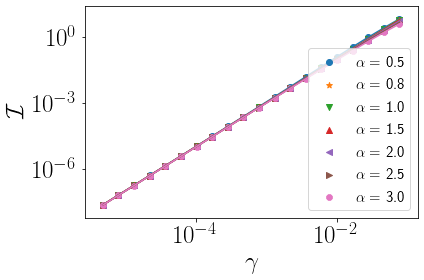

In [341]:
markers  = ['o','*', 'v', '^', '<', '>', '8', 's', 'p', 'h']

_fontsize = 25
var = gammas
target = I

fig = plt.figure()
ax = fig.gca()
ax.loglog(var, target.T)
for i, alpha in enumerate(alphas):
    ax.scatter(var, target[i,:], marker=markers[i], label=r'$\alpha =$ %2.1f'% alpha)
plt.xlabel(r'$\gamma$', fontsize=_fontsize)
plt.ylabel(r'$\mathcal{I}$', fontsize=_fontsize)
ax.tick_params(axis='both', which='major', labelsize=_fontsize)
plt.legend([r'$\alpha =$ %2.1f'% alpha for alpha in alphas], fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()

# $\tau^2 = \epsilon, \gamma = \tau^\alpha$? In this case, $\mathcal{I} = O(\tau^{2\alpha} + \tau^4) = O(\epsilon^\alpha + \epsilon^2)$ according to the Corollary 3.10, which does not correspond to $\tau = o(\sqrt{\epsilon})$.

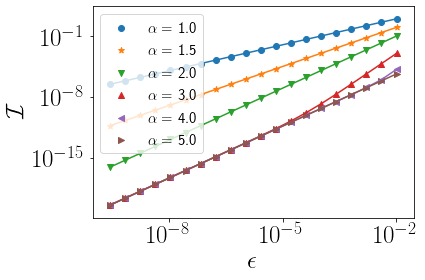

In [357]:
alphas = [1, 1.5, 2, 3, 4, 5]
n_alpha = len(alphas)
n = 20
epss   = np.power(0.4, range(5, n+5))
TRC = np.zeros((n_alpha, n))
TRCBC = np.zeros((n_alpha, n))
BIAS = np.zeros((n_alpha, n))
I = np.zeros((n_alpha, n))

for j, eps in enumerate(epss):
    
    w, v = get_eigs(eps)
    for i, alpha in enumerate(alphas):
        tau = eps ** (1/2)
        gamma = tau ** alpha
        d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
        d_inv = 1./d  
        prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
        # B/gamma^2
        B_over_gamma2 = B / (gamma * gamma)
        # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
        post_inv  = prior_inv + B_over_gamma2
        # C^{-1}
        post = post_inv.I
        bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')
       
        #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
        BIAS[i,j] = bias ** 2
       
        trC = sp.trace(post)
        TRC[i,j] = trC

        post2 = post.dot(post)
        trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
        TRCBC[i, j] = trCBC/(gamma**2.)
        
        I[i, j] = K * trC + trCBC + bias ** 2

var = epss
target = I

fig = plt.figure()
ax = fig.gca()
ax.loglog(var, target.T)
for i, alpha in enumerate(alphas):
    ax.scatter(var, target[i,:], marker=markers[i], label=r'$\alpha =$ %2.1f'% alpha)
plt.xlabel(r'$\epsilon$', fontsize=_fontsize)
plt.ylabel(r'$\mathcal{I}$', fontsize=_fontsize)
ax.tick_params(axis='both', which='major', labelsize=_fontsize)
plt.legend([r'$\alpha =$ %2.1f'% alpha for alpha in alphas], fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()

1.000109891496568


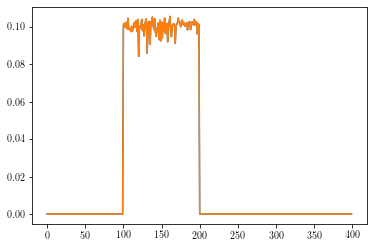

In [287]:
x = post@B_over_gamma2@u
plt.plot(x[:,1])
plt.plot(u[:,1])
print(sp.linalg.norm(x[:,2], ord='fro'))

# $\gamma = o(\sqrt{\epsilon}), \tau = \Xi\epsilon^{\frac{1}{2\alpha}}$ (how are we supposed to get $\Xi$?). In this case, $\mathcal{I} = O(\epsilon + \epsilon^{2/\alpha})$ according to theorem 1.3.

I have a couple issues with this case. 

- $\tau$ is not directly tied to $\gamma$ but rather to $\epsilon$, i.e. $\tau = \Xi\epsilon^{\frac{1}{2\alpha}}$, which may break the usual identity $\gamma = \tau^\alpha$ if $\gamma = o(\sqrt{\epsilon})$ instead of $\gamma = \sqrt{\epsilon}$.
- The numerics does not really match up in this case. 
- I don't really see the connection between theorem 1.3 and corrolary 3.10.

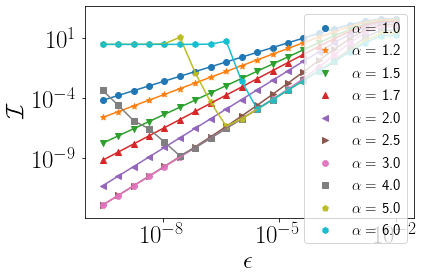

In [394]:
alphas = [1, 1.2, 1.5, 1.7, 2, 2.5, 3, 4 ,5 ,6]
n_alpha = len(alphas)
n = 20
epss   = np.power(0.4, range(5, n+5))
TRC = np.zeros((n_alpha, n))
TRCBC = np.zeros((n_alpha, n))
BIAS = np.zeros((n_alpha, n))
I = np.zeros((n_alpha, n))

for j, eps in enumerate(epss):
    w, v = get_eigs(eps)
    for i, alpha in enumerate(alphas):
        xi = sp.sparse.linalg.norm(Wo)
        gamma = min(0.9, eps * xi) 
        tau = min(0.9, (2 * xi * eps) ** (1/ (2))) 
        d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
        d_inv = 1./d  
        prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
        # B/gamma^2
        B_over_gamma2 = B / (gamma * gamma)
        # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
        post_inv  = prior_inv + B_over_gamma2
        # C^{-1}
        post = post_inv.I
        bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')
       
        #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
        BIAS[i,j] = bias ** 2
       
        trC = sp.trace(post)
        TRC[i,j] = trC

        post2 = post.dot(post)
        trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
        TRCBC[i, j] = trCBC/(gamma**2.)
        
        I[i, j] = K * trC + trCBC + bias ** 2

var = epss
target = I

fig = plt.figure()
ax = fig.gca()
ax.loglog(var, target.T)
for i, alpha in enumerate(alphas):
    ax.scatter(var, target[i,:], marker=markers[i], label=r'$\alpha =$ %2.1f'% alpha)
plt.xlabel(r'$\epsilon$', fontsize=_fontsize)
plt.ylabel(r'$\mathcal{I}$', fontsize=_fontsize)
ax.tick_params(axis='both', which='major', labelsize=_fontsize)
plt.legend([r'$\alpha =$ %2.1f'% alpha for alpha in alphas], fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()